In [1]:
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model='gpt-4o-mini')

In [3]:
from langsmith import Client

client = Client()

In [4]:
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings

vector_store = Chroma(
    embedding_function=OpenAIEmbeddings(model='text-embedding-3-large'),
    collection_name='income_tax_collections',
    persist_directory='./income_tax_collections'
)
retriever = vector_store.as_retriever(search_kwargs={'k': 3})

In [5]:
from typing import Literal
from typing_extensions import TypedDict
from langchain_core.prompts import ChatPromptTemplate

class AgentState(TypedDict):
    query: str
    context: list
    answer: str

In [6]:
from langchain_community.tools import TavilySearchResults

tavily_search_tool = TavilySearchResults(
    max_results=3,
    search_depth="advanced",
    include_answer=True,
    include_raw_content=True,
    include_images=True,
)

/var/folders/t1/61s5wdsn7rdd5nsx4w3tnxz80000gn/T/ipykernel_28386/1696486342.py:3: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the `langchain-tavily package and should be used instead. To use it run `pip install -U `langchain-tavily` and import as `from `langchain_tavily import TavilySearch``.
  tavily_search_tool = TavilySearchResults(


In [7]:
def web_search(state: AgentState) -> AgentState:
    """
    'web_search' Node
    : 주어진 state를 기반으로 웹 검색을 수행한다.

    Args:
        - state(AgentState): 사용자의 질문을 포함한 에이전트의 현재 state

    Returns:
        - AgentState: 웹 검색 결과가 추가된 state
    """
    
    query = state['query']
    
    # 웹 검색 도구 활용
    results = tavily_search_tool.invoke(query)
    
    return {'context': results}

In [8]:
rag_prompt = client.pull_prompt("rlm/rag-prompt", include_model=True)

def web_generate(state: AgentState) -> AgentState:
    """
    'web_generate' Node
    : 사용자의 질문과 웹 검색된 문서를 기반으로 응답을 생성한다.

    Args:
        - state(AgentState): 사용자의 질문과 검색된 문서를 포함한 에이전트의 현재 state

    Returns:
        - AgentState: 생성된 응답이 추가된 state
    """
    
    query = state['query']
    context = state['context']
    
    rag_chain = rag_prompt | llm
    ai_message = rag_chain.invoke({'question': query, 'context': context})
    
    return {'answer': ai_message}

In [9]:
def basic_generate(state: AgentState) -> AgentState:
    """
    'basic_generate' Node
    : 사용자의 질문에 대한 응답을 생성한다.

    Args:
        - state(AgentState): 사용자의 질문을 포함한 에이전트의 현재 state

    Returns:
        - AgentState: 생성된 응답이 추가된 state
    """
    
    query = state['query']
    
    # LLM에게 직접 질문
    ai_message = llm.invoke(query)
    
    return {'answer': ai_message}

In [10]:
from pydantic import BaseModel, Field

class Router(BaseModel):
    target: Literal['vector_store', 'llm', 'web_search'] = Field(
        description="The target for the query to answer"
    )
    
structured_llm = llm.with_structured_output(Router)

In [ ]:
route_system_prompt = """
You are an expert at routing a user's question to 'vector_store', 'llm', or 'web_search'.

if you think the question is simple enough use 'llm'.
if you think you need to search the web to answer the question use 'web_search'.

- 'vector_store' contains information about income tax up to December 2024.
"""

route_prompt = ChatPromptTemplate.from_messages([
    ('system', route_system_prompt),
    ('user', '{query}')
])

def route(state: AgentState) -> Literal['vector_store', 'llm', 'web_search']:
    """
    'route' Node
    : 사용자 질문의 적절한 경로를 결정한다.

    Args:
        - state(AgentState): 사용자의 질문을 포함한 에이전트의 현재 state

    Returns:
        - Literal['vector_store', 'llm', 'web_search']: 질문을 처리하기 위한 경로를 나타내는 문자열
    """
    
    query = state['query']
    
    # 라우터 체인
    route_chain = route_prompt | structured_llm
    ai_message = route_chain.invoke({'query': query})
    
    print(f"target=={ai_message.target}")
    
    return ai_message.target

In [12]:
from langgraph.graph import StateGraph, START, END
from graph.income_tax_graph import graph as income_tax_graph

graph_builder = StateGraph(AgentState)

# nodes
graph_builder.add_node('web_search', web_search)
graph_builder.add_node('web_generate', web_generate)
graph_builder.add_node('basic_generate', basic_generate)
graph_builder.add_node('income_tax_agent', income_tax_graph)

# edges
graph_builder.add_conditional_edges(
    START,
    route,
    {
        'vector_store': 'income_tax_agent',
        'llm': 'basic_generate',
        'web_search': 'web_search'
    }
)
graph_builder.add_edge('web_search', 'web_generate')
graph_builder.add_edge('web_generate', END)
graph_builder.add_edge('basic_generate', END)
graph_builder.add_edge('income_tax_agent', END)

In [13]:
graph = graph_builder.compile()

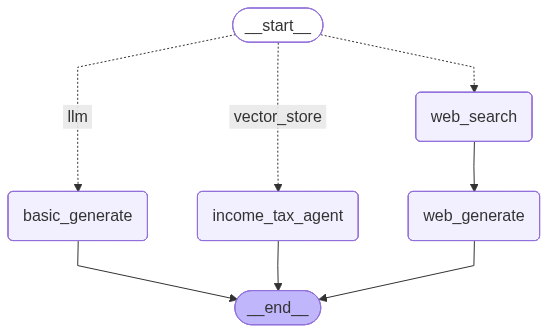

In [14]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [17]:
query1 = "연봉 5천만원인 거주자가 납부해야 하는 소득세는 얼마인가요?"
query2 = "군자역 맛집을 알려주세요."
query3 = "대한민국의 수도는 어디인가요?"
initial_state = {'query': query1}

graph.invoke(initial_state)

target==vector_store


{'query': '연봉 5천만원인 거주자가 납부해야 하는 소득세는 얼마인가요?',
 'context': [Document(id='b7f55e91-a27f-4f35-b2cd-79e060fa4431', metadata={'source': '/Users/ksj/MyProjects/llm/inflearn-langgrath-lecture/docs/income_tax.txt'}, page_content='5년 이하: 30만원 → 납입연수\n5년 초과 10년 이하: 150만원 + 50만원 × (납입연수 - 5년)\n10년 초과 20년 이하: 400만원 + 80만원 × (납입연수 - 10년)\n20년 초과: 1,200만원 + 120만원 × (납입연수 - 20년)\n\n② 직장근로자 초과관세환급금을 분배하여 지급받는 경우 세액의 계산 방법 등 필요한 사항은 대통령령으로 정한다. \n<대통령 2014. 12. 23.>\n<전문개정 2009. 12. 31.>\n제64조(부동산매매업자에 대한 세액 계산의 특례)\n1) 대통령령으로 정하는 부동산매매업(이하 “부동산매매업”이라 한다)을 영위하는 거주자가 이하 “부동산매매업자”라 한다)로서 종합소득세법에 제104조제1항제1호(본항을 포함한다) 및 제103조 또는 같은 조 제7항 각 호의 어느 하나에 해당하는 자산의 매매자익(이하 “주택등매매차익”이라 한다)이 있는 자의 종합소득 산출세액은 다음 각 호의 세액 중 많은 것으로 한다. \n<개정 2014. 12. 23., 2017. 12. 19., 2020. 12. 29.>\n1. 종합소득 산출세액\n\n다음 각 목에 따른 세액의 합계액\n  가. 주택등매매차익에 따른 세율을 적용하여 산출한 세액의 합계액\n  나. 종합소득세법 제55조에 따라 주택등매매차익에 대한 개별세액을 공제한 금액을 과세표준으로 하고 이에 제55조에 따른 세율을 적용하여 산출세액'),
  Document(id='f5c74d69-d34a-4bfe-80aa-e6ccbc22c35a', metadata={'source':